In [1]:
from google.colab import drive
import torch
drive.mount('/content/drive', force_remount=True)

MODEL_SAVE_DIR = "/content/drive/MyDrive/models"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive


In [2]:
%run "/content/drive/MyDrive/Colab Notebooks/CNN_Binary_Classifier.ipynb"

Branch Output Dimensions:
LEFT branch:
	Output shape: torch.Size([1, 64, 14])
	Features per sample: 896

RIGHT branch:
	Output shape: torch.Size([1, 64, 6])
	Features per sample: 384



In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MultimodalDataset(Dataset):
    def __init__(self, data_dict, labels):
        """
        Args:
            data_dict: Dictionary of signals {signal_name: tensor(shape [n_samples, 1, n_timesteps])}
            labels: Tensor of labels (n_samples,)
        """
        # Validate consistent sample count
        self.length = len(labels)
        for signal, data in data_dict.items():
            assert len(data) == self.length, \
                f"Signal {signal} has {len(data)} samples, expected {self.length}"

        self.data_dict = data_dict
        self.labels = labels

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return {signal: data[idx] for signal, data in self.data_dict.items()}, self.labels[idx]

# Load and preprocess data
X_train = {}
y_train = None
X_test = {}
y_test = None

with np.load('/content/drive/MyDrive/sleepdata/telemetry_all_train.npz') as train_data:
    X_train["EEG Fpz-Cz"] = torch.tensor(train_data["EEG Fpz-Cz"], dtype=torch.float32).unsqueeze(1)
    X_train["EEG Pz-Oz"] = torch.tensor(train_data["EEG Pz-Oz"], dtype=torch.float32).unsqueeze(1)
    X_train["EOG horizontal"] = torch.tensor(train_data["EOG horizontal"], dtype=torch.float32).unsqueeze(1)
    X_train["EMG submental"] = torch.tensor(train_data["EMG submental"], dtype=torch.float32).unsqueeze(1)
    y_train = torch.tensor(train_data["y"], dtype=torch.long)  # Use long for classification

with np.load('/content/drive/MyDrive/sleepdata/telemetry_all_test.npz') as test_data:
    X_test["EEG Fpz-Cz"] = torch.tensor(test_data["EEG Fpz-Cz"], dtype=torch.float32).unsqueeze(1)
    X_test["EEG Pz-Oz"] = torch.tensor(test_data["EEG Pz-Oz"], dtype=torch.float32).unsqueeze(1)
    X_test["EOG horizontal"] = torch.tensor(test_data["EOG horizontal"], dtype=torch.float32).unsqueeze(1)
    X_test["EMG submental"] = torch.tensor(test_data["EMG submental"], dtype=torch.float32).unsqueeze(1)
    y_test = torch.tensor(test_data["y"], dtype=torch.long)  # Use long for classification


# Create datasets
train_dataset = MultimodalDataset(X_train, y_train)
test_dataset = MultimodalDataset(X_test, y_test)

print(y_test)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    pin_memory=True if torch.cuda.is_available() else False
)

# Verify the data loading
print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

# Test one batch
for batch_dict, labels in train_loader:
    print("\nBatch sample:")
    for signal, data in batch_dict.items():
        print(f"{signal}: shape={data.shape}, dtype={data.dtype}")
    print(f"Labels: shape={labels.shape}, dtype={labels.dtype}")
    break

tensor([1, 1, 1,  ..., 0, 0, 0])
Train batches: 1018
Test batches: 193

Batch sample:
EEG Fpz-Cz: shape=torch.Size([32, 1, 3000]), dtype=torch.float32
EEG Pz-Oz: shape=torch.Size([32, 1, 3000]), dtype=torch.float32
EOG horizontal: shape=torch.Size([32, 1, 3000]), dtype=torch.float32
EMG submental: shape=torch.Size([32, 1, 3000]), dtype=torch.float32
Labels: shape=torch.Size([32]), dtype=torch.int64


In [4]:
import torch
import torch.nn as nn

class _FFE(nn.Module):
    """Frozen Feature Extractinator
    Freezes the Features and then Extractinates them
    """
    def __init__(self, model):
        super().__init__()
        self.model = model
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.eval()

    def forward(self, x):
        branch_outputs = [branch(x).flatten(1) for branch in self.model.branches.values()]
        combined = torch.cat(branch_outputs, dim=1)
        return self.model.fc(combined) # -> (batch_size, 32)


class EnsembleModel(nn.Module):
    def __init__(self, models, signal_names):
        """
        models = {
            "s1": [m1, m2, m3, m4],
            ...
            "s4": [m13, m14, m15, m16]
        }
        signal_names = ["s1", "s2", "s3", "s4"]
        """
        super().__init__()
        self.signal_names = signal_names

        self.feature_extractors = nn.ModuleDict()
        for signal, model_list in models.items():
            self.feature_extractors[signal] = nn.ModuleList([
                _FFE(model) for model in model_list
            ])


        self.mlp = nn.Sequential(
            nn.Linear(20 * 32, 256), # (20 binary each outputting a 32 embedding) -> 256
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 5)  # 5 sleep stages
        )

    def forward(self, x_data):
        """
        x_data: Dictionary of tensors {signal_name: (batch, 1, n_samples)}
        Returns:
            logits: (batch, 5) sleep stage logits
        """
        all_features = []

        for signal in self.signal_names:
            signal_data = x_data[signal]
            signal_models = self.feature_extractors[signal]

            for ffe in signal_models:
                features = ffe(signal_data)
                all_features.append(features)

        combined = torch.cat(all_features, dim=1)

        return self.mlp(combined)

In [5]:
import torch

def load_model(model_path):
    checkpoint = torch.load(model_path, map_location=device)

    model_args = checkpoint["model_args"]
    model = CNN_BinaryClassifier(
        name=model_args["name"],
        n_samples=model_args["n_samples"],
        branch_configs=model_args["branch_configs"]
    )

    model.load_state_dict(checkpoint["state_dict"])
    return model


In [6]:
models_dict = {
    "EEG Fpz-Cz": [
        load_model(f"{MODEL_SAVE_DIR}/telemetry_EEG_Fpz-Cz_wake_classifier.pt"),
        load_model(f"{MODEL_SAVE_DIR}/telemetry_EEG_Fpz-Cz_N1_classifier.pt"),
        load_model(f"{MODEL_SAVE_DIR}/telemetry_EEG_Fpz-Cz_N2_classifier.pt"),
        load_model(f"{MODEL_SAVE_DIR}/telemetry_EEG_Fpz-Cz_N3_classifier.pt"),
        load_model(f"{MODEL_SAVE_DIR}/telemetry_EEG_Fpz-Cz_REM_classifier.pt")
    ],
    "EEG Pz-Oz": [
        load_model(f"{MODEL_SAVE_DIR}/telemetry_EEG_Pz-Oz_wake_classifier.pt"),
        load_model(f"{MODEL_SAVE_DIR}/telemetry_EEG_Pz-Oz_N1_classifier.pt"),
        load_model(f"{MODEL_SAVE_DIR}/telemetry_EEG_Pz-Oz_N2_classifier.pt"),
        load_model(f"{MODEL_SAVE_DIR}/telemetry_EEG_Pz-Oz_N3_classifier.pt"),
        load_model(f"{MODEL_SAVE_DIR}/telemetry_EEG_Pz-Oz_REM_classifier.pt")
    ],
    "EOG horizontal": [
        load_model(f"{MODEL_SAVE_DIR}/telemetry_EOG_horizontal_wake_classifier.pt"),
        load_model(f"{MODEL_SAVE_DIR}/telemetry_EOG_horizontal_N1_classifier.pt"),
        load_model(f"{MODEL_SAVE_DIR}/telemetry_EOG_horizontal_N2_classifier.pt"),
        load_model(f"{MODEL_SAVE_DIR}/telemetry_EOG_horizontal_N3_classifier.pt"),
        load_model(f"{MODEL_SAVE_DIR}/telemetry_EOG_horizontal_REM_classifier.pt")
    ],
    "EMG submental": [
        load_model(f"{MODEL_SAVE_DIR}/telemetry_EMG_submental_wake_classifier.pt"),
        load_model(f"{MODEL_SAVE_DIR}/telemetry_EMG_submental_N1_classifier.pt"),
        load_model(f"{MODEL_SAVE_DIR}/telemetry_EMG_submental_N2_classifier.pt"),
        load_model(f"{MODEL_SAVE_DIR}/telemetry_EMG_submental_N3_classifier.pt"),
        load_model(f"{MODEL_SAVE_DIR}/telemetry_EMG_submental_REM_classifier.pt")
    ]
}


signal_names = ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal", "EMG submental"]



In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report
from torch.utils.tensorboard import SummaryWriter

def train_model(model, device, train_loader, test_loader, log_tensorboard=False, epochs=5, lr=1e-4, wd=1e-4, class_names=None):

    print(f"Running for {epochs} epochs...")
    writer = SummaryWriter() if log_tensorboard else None
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    best_test_f1 = 0.0
    best_model_state = model.state_dict()

    if class_names is None:
        class_names = [f"Class {i}" for i in range(5)]

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        all_train_preds = []
        all_train_targets = []

        for batch in train_loader:
            x_dict, labels = batch
            x_dict = {key: val.to(device) for key, val in x_dict.items()}
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(x_dict).to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)

            _, preds = torch.max(outputs, 1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_targets.extend(labels.cpu().numpy())

        train_loss /= len(train_loader.dataset)
        train_acc = np.mean(np.array(all_train_preds) == np.array(all_train_targets))
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
            all_train_targets, all_train_preds, average='weighted', zero_division=0
        )

        model.eval()
        test_loss = 0.0
        all_test_preds = []
        all_test_targets = []
        all_test_probs = []

        with torch.inference_mode():
            for batch in test_loader:
                x_dict, labels = batch
                x_dict = {key: val.to(device) for key, val in x_dict.items()}
                labels = labels.to(device)

                outputs = model(x_dict)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * labels.size(0)

                probs = torch.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)

                all_test_preds.extend(preds.cpu().numpy())
                all_test_targets.extend(labels.cpu().numpy())
                all_test_probs.extend(probs.cpu().numpy())

        test_loss /= len(test_loader.dataset)
        test_acc = np.mean(np.array(all_test_preds) == np.array(all_test_targets))
        test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
            all_test_targets, all_test_preds, average='weighted', zero_division=0
        )

        if test_f1 > best_test_f1:
            best_test_f1 = test_f1
            best_model_state = model.state_dict()

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.4f}, "
              f"Precision={train_precision:.4f}, Recall={train_recall:.4f}, F1={train_f1:.4f}")
        print(f"  Test:  Loss={test_loss:.4f}, Acc={test_acc:.4f}, "
              f"Precision={test_precision:.4f}, Recall={test_recall:.4f}, F1={test_f1:.4f}")

        print("\nTest Classification Report:")
        print(classification_report(
            all_test_targets,
            all_test_preds,
            target_names=class_names,
            digits=4,
            zero_division=0
            ))

        if writer:
            writer.add_scalar("Loss/Train", train_loss, epoch)
            writer.add_scalar("Loss/Test", test_loss, epoch)
            writer.add_scalar("Accuracy/Train", train_acc, epoch)
            writer.add_scalar("Accuracy/Test", test_acc, epoch)
            writer.add_scalar("F1/Train", train_f1, epoch)
            writer.add_scalar("F1/Test", test_f1, epoch)
            writer.add_scalar("Precision/Train", train_precision, epoch)
            writer.add_scalar("Precision/Test", test_precision, epoch)
            writer.add_scalar("Recall/Train", train_recall, epoch)
            writer.add_scalar("Recall/Test", test_recall, epoch)

            for i, class_name in enumerate(class_names):
                class_probs = [p[i] for p in all_test_probs]
                class_targets = [1 if t == i else 0 for t in all_test_targets]
                if sum(class_targets) > 0:
                    writer.add_pr_curve(
                        f"PR_Curve/{class_name}",
                        np.array(class_targets),
                        np.array(class_probs),
                        global_step=epoch
                    )

    if writer:
        writer.close()

    return model.state_dict()

In [10]:
model = EnsembleModel(models_dict, signal_names).to(device)

class_names = ["Wake", "N1", "N2", "N3", "REM"]

trained_state = train_model(
    model=model,
    device=device,
    train_loader=train_loader,
    test_loader=test_loader,
    num_classes=5,
    log_tensorboard=True,
    epochs=5,
    lr=5e-5,
    wd=1e-4,
    class_names=class_names
)

model.load_state_dict(trained_state)

Running for 5 epochs...
Epoch 1/5
  Train: Loss=0.4407, Acc=0.8396, Precision=0.8347, Recall=0.8396, F1=0.8346
  Test:  Loss=0.6058, Acc=0.8250, Precision=0.8546, Recall=0.8250, F1=0.8282

Test Classification Report:
              precision    recall  f1-score   support

        Wake     0.8153    0.8514    0.8330       451
          N1     0.6594    0.6893    0.6740       486
          N2     0.9607    0.7587    0.8478      3092
          N3     0.6135    0.9749    0.7531       718
         REM     0.8242    0.9330    0.8752      1402

    accuracy                         0.8250      6149
   macro avg     0.7746    0.8415    0.7966      6149
weighted avg     0.8546    0.8250    0.8282      6149

Epoch 2/5
  Train: Loss=0.3251, Acc=0.8697, Precision=0.8679, Recall=0.8697, F1=0.8686
  Test:  Loss=0.5692, Acc=0.8348, Precision=0.8607, Recall=0.8348, F1=0.8395

Test Classification Report:
              precision    recall  f1-score   support

        Wake     0.8457    0.8625    0.8540   

<All keys matched successfully>

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def plot_sample_predictions(model, device, data_dict, sample_idx, class_names, true_label=None, pred_label=None):
    signals = {
        "EEG Fpz-Cz": data_dict["EEG Fpz-Cz"][sample_idx],
        "EEG Pz-Oz": data_dict["EEG Pz-Oz"][sample_idx],
        "EOG horizontal": data_dict["EOG horizontal"][sample_idx],
        "EMG submental": data_dict["EMG submental"][sample_idx],
    }

    if true_label is None:
        true_label = data_dict["y"][sample_idx]

    if pred_label is None:
        model.eval()
        with torch.inference_mode():
            input_dict = {}
            for ch, signal in signals.items():
                input_dict[ch] = torch.tensor(signal, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

            output = model(input_dict)
            probs = torch.softmax(output, dim=1)
            pred_label = torch.argmax(probs, dim=1).item()

    fig, axs = plt.subplots(4, 1, figsize=(14, 10))
    fig.suptitle(f"Sample {sample_idx} - True: {class_names[true_label]}, Pred: {class_names[pred_label]}",
                 fontsize=16, fontweight='bold')

    for i, (ch, signal) in enumerate(signals.items()):
        axs[i].plot(signal, color='royalblue')
        axs[i].set_title(f"{ch} ({len(signal)} samples)", fontsize=12)
        axs[i].set_ylabel("Amplitude", fontsize=10)
        axs[i].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return true_label, pred_label

def analyze_predictions(model, device, data_dict, class_names):
    all_true = []
    all_preds = []

    model.eval()
    with torch.inference_mode():
        for i in range(len(data_dict["y"])):
            input_dict = {}
            for ch in ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal", "EMG submental"]: # TODO: why is this not a constant list teitur
                signal = data_dict[ch][i]
                input_dict[ch] = torch.tensor(signal, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

            true_label = data_dict["y"][i]

            output = model(input_dict)
            pred_label = torch.argmax(output, dim=1).item()

            all_true.append(true_label)
            all_preds.append(pred_label)

    all_true = np.array(all_true)
    all_preds = np.array(all_preds)

    cm = confusion_matrix(all_true, all_preds, labels=range(len(class_names)))

    plt.figure(figsize=(10, 8))

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=class_names
    )
    disp.plot(cmap="Blues", values_format="d")  # 'd' for integer formatting
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")

    plt.show()

    for class_idx, class_name in enumerate(class_names):
        print(f"\n===== {class_name} Analysis =====")

        # True Positives (TP): Correctly predicted as this class
        tp_indices = np.where((all_true == class_idx) & (all_preds == class_idx))[0]
        print(f"True Positives: {len(tp_indices)} samples")

        # False Positives (FP): Predicted as this class but actually not
        fp_indices = np.where((all_true != class_idx) & (all_preds == class_idx))[0]
        print(f"False Positives: {len(fp_indices)} samples")

        # False Negatives (FN): Actually this class but predicted as something else
        fn_indices = np.where((all_true == class_idx) & (all_preds != class_idx))[0]
        print(f"False Negatives: {len(fn_indices)} samples")

        # True Negatives (TN): Not this class and not predicted as that class
        tn_indices = np.where((all_true != class_idx) & (all_preds == all_true))[0]
        print(f"True Negatives: {len(tn_indices)} samples")

        if len(tp_indices) > 0:
            print("\nExample True Positive:")
            plot_sample_predictions(model, device, data_dict, tp_indices[np.random.choice(len(tp_indices))], class_names)
        else:
            print("Your model sux, NO TRUE POSITIVES")

        if len(fp_indices) > 0:
            print("\nExample False Positive:")
            plot_sample_predictions(model, device, data_dict, fp_indices[np.random.choice(len(fp_indices))], class_names)
        else:
            print("Wow, good model... maybe too good, NO FALSE POSITIVES")

        if len(fn_indices) > 0:
            print("\nExample False Negative:")
            plot_sample_predictions(model, device, data_dict, fn_indices[np.random.choice(len(fn_indices))], class_names)
        else:
            print("hm... NO FALSE NEGATIVES?")


        if len(tn_indices) > 0:
            print("\nExample True Negative:")
            plot_sample_predictions(model, device, data_dict, tn_indices[np.random.choice(len(tn_indices))], class_names)

        else:
            print("no true negatives? Bro get out")


Test Classification Report:
              precision    recall  f1-score   support

        Wake     0.8794    0.8404    0.8594       451
          N1     0.6163    0.7140    0.6616       486
          N2     0.9557    0.7542    0.8431      3092
          N3     0.6590    0.9582    0.7809       718
         REM     0.7893    0.9408    0.8584      1402

    accuracy                         0.8237      6149
   macro avg     0.7800    0.8415    0.8007      6149
weighted avg     0.8507    0.8237    0.8262      6149








<Figure size 1000x800 with 0 Axes>

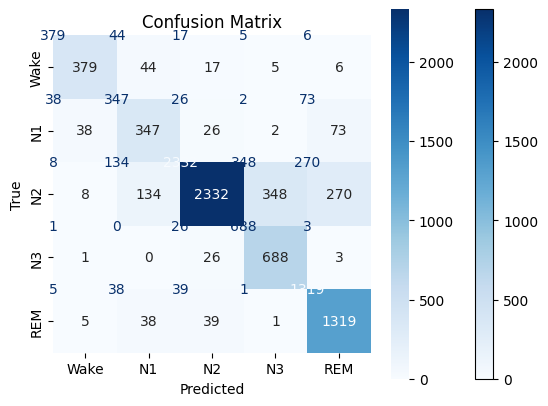


===== Wake Analysis =====
True Positives: 379 samples
False Positives: 52 samples
False Negatives: 72 samples
True Negatives: 4686 samples

Example True Positive:


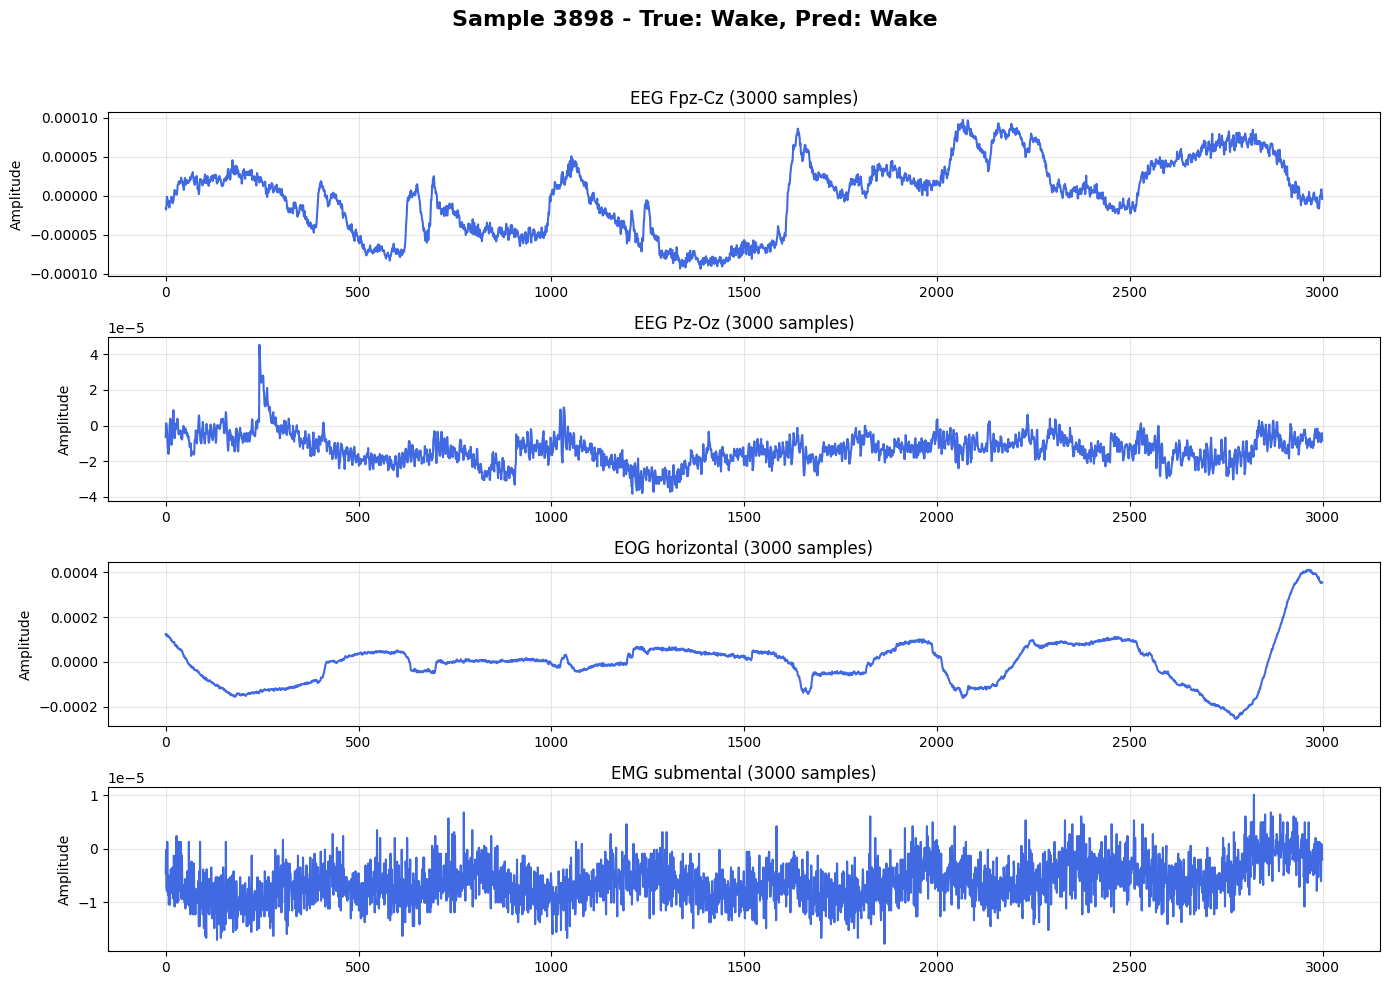


Example False Positive:


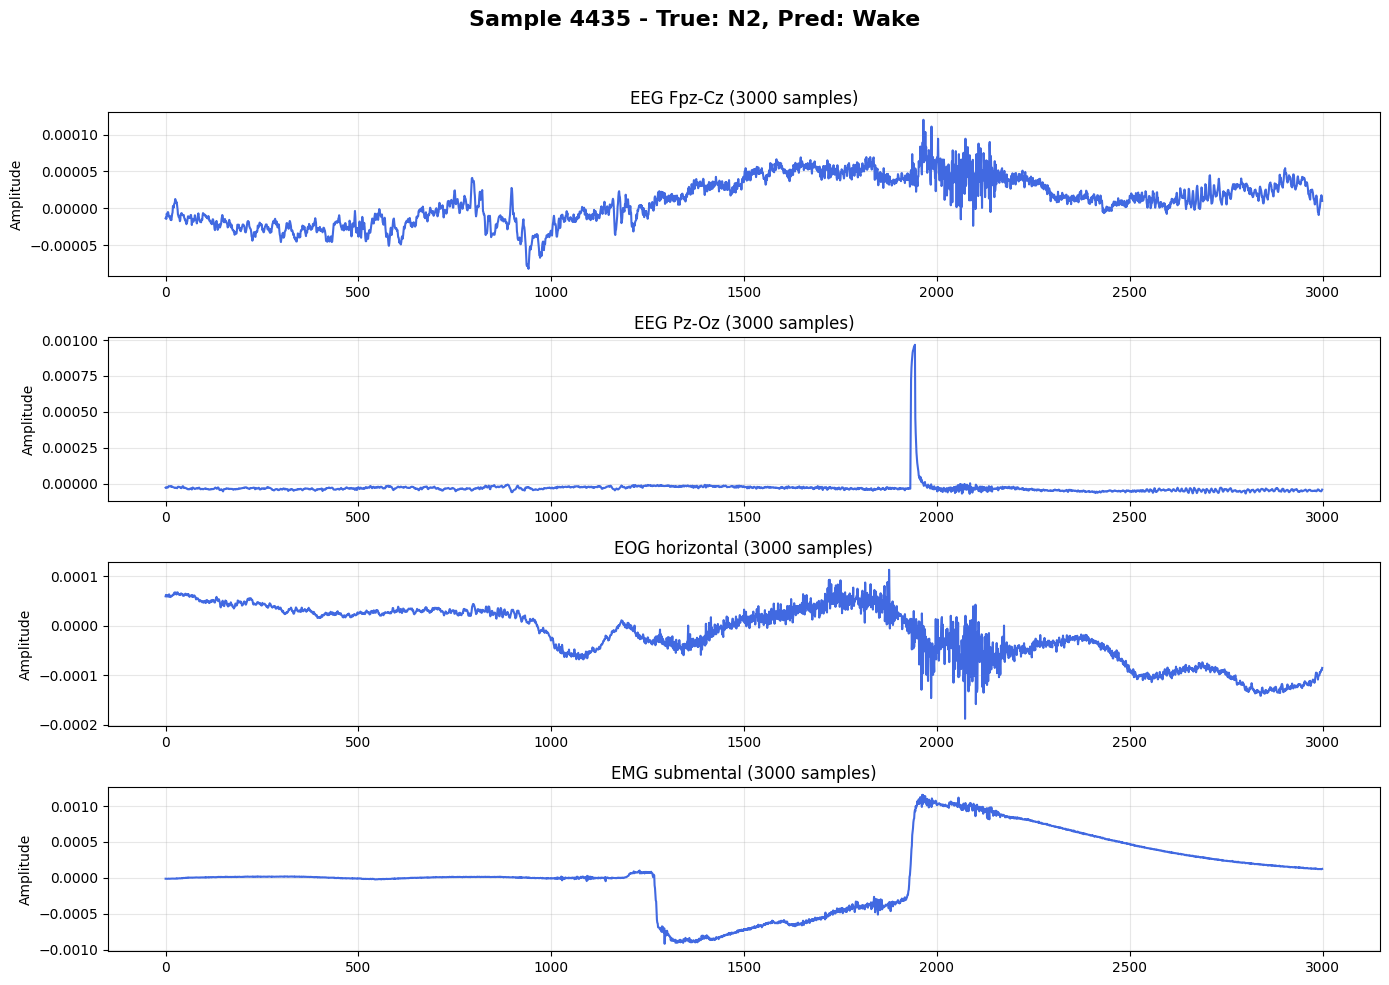


Example False Negative:


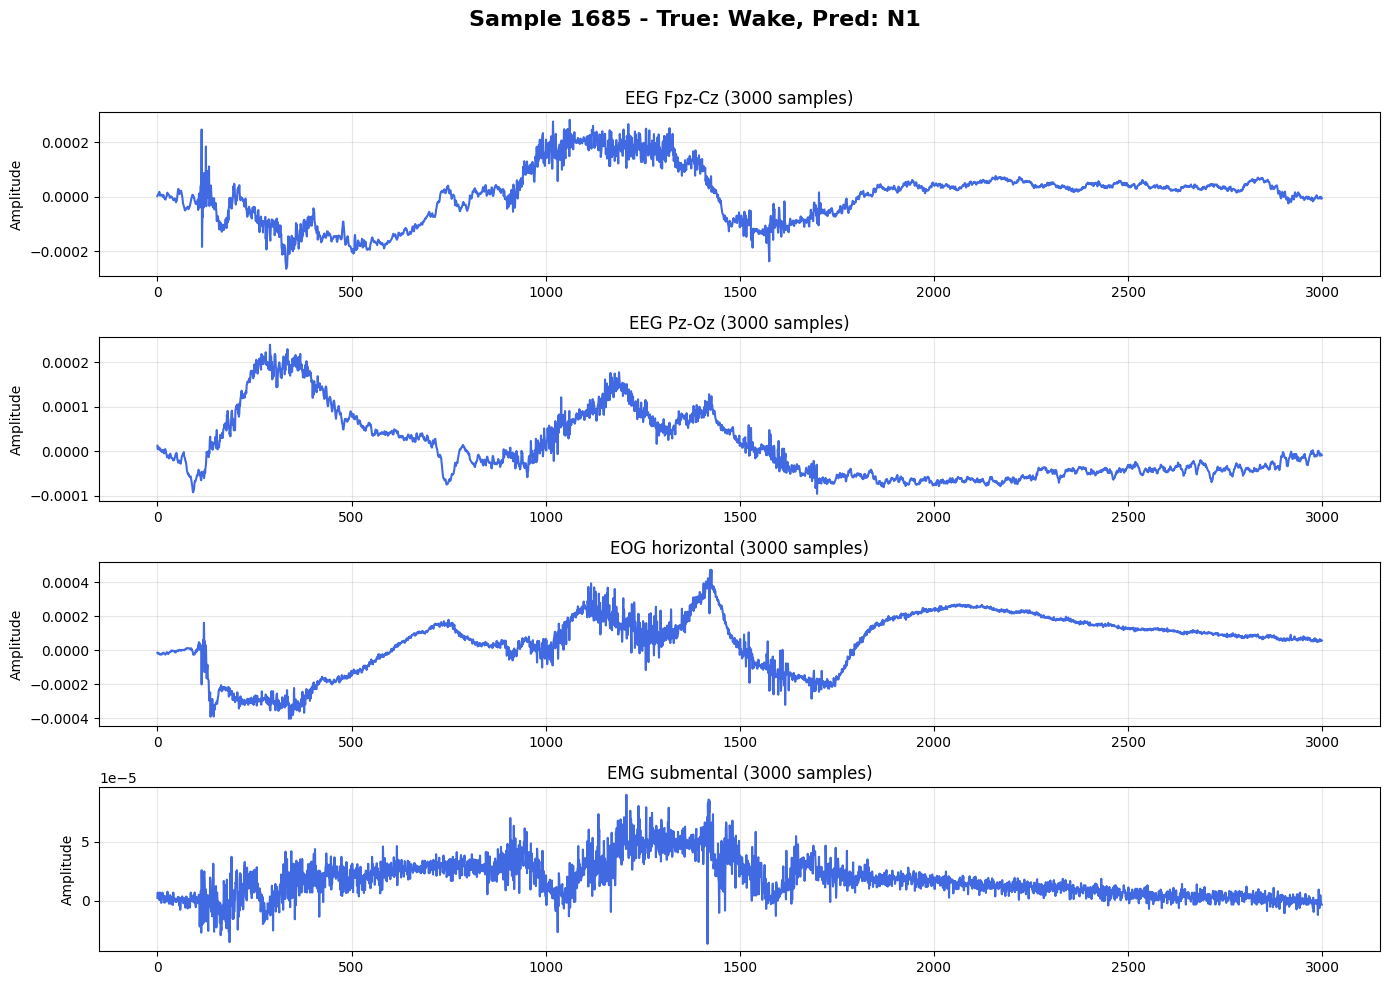


Example True Negative:


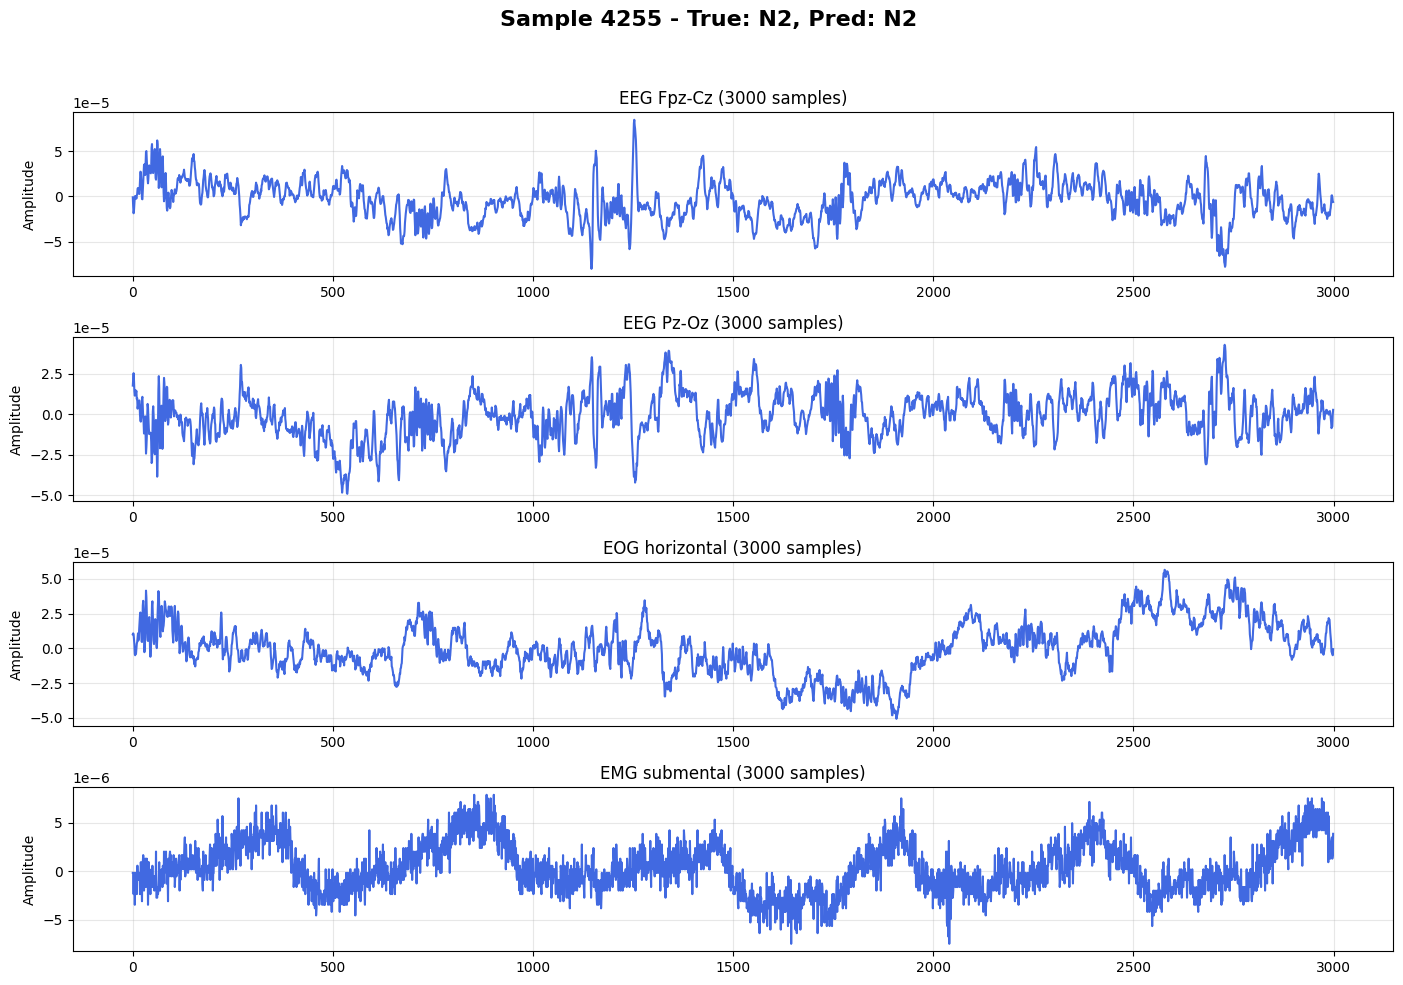


===== N1 Analysis =====
True Positives: 347 samples
False Positives: 216 samples
False Negatives: 139 samples
True Negatives: 4718 samples

Example True Positive:


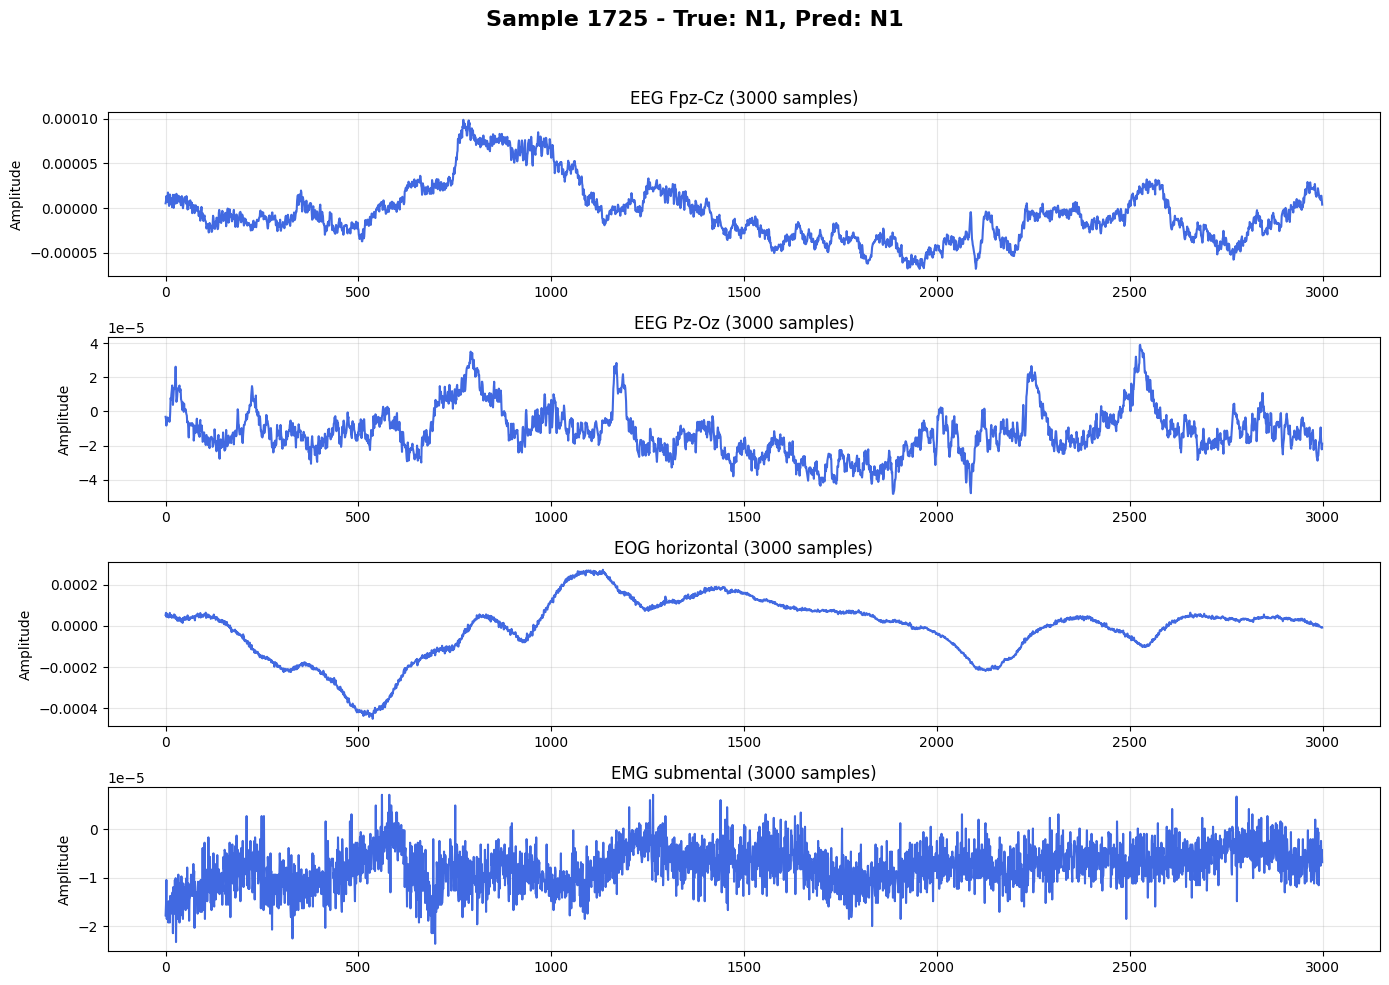


Example False Positive:


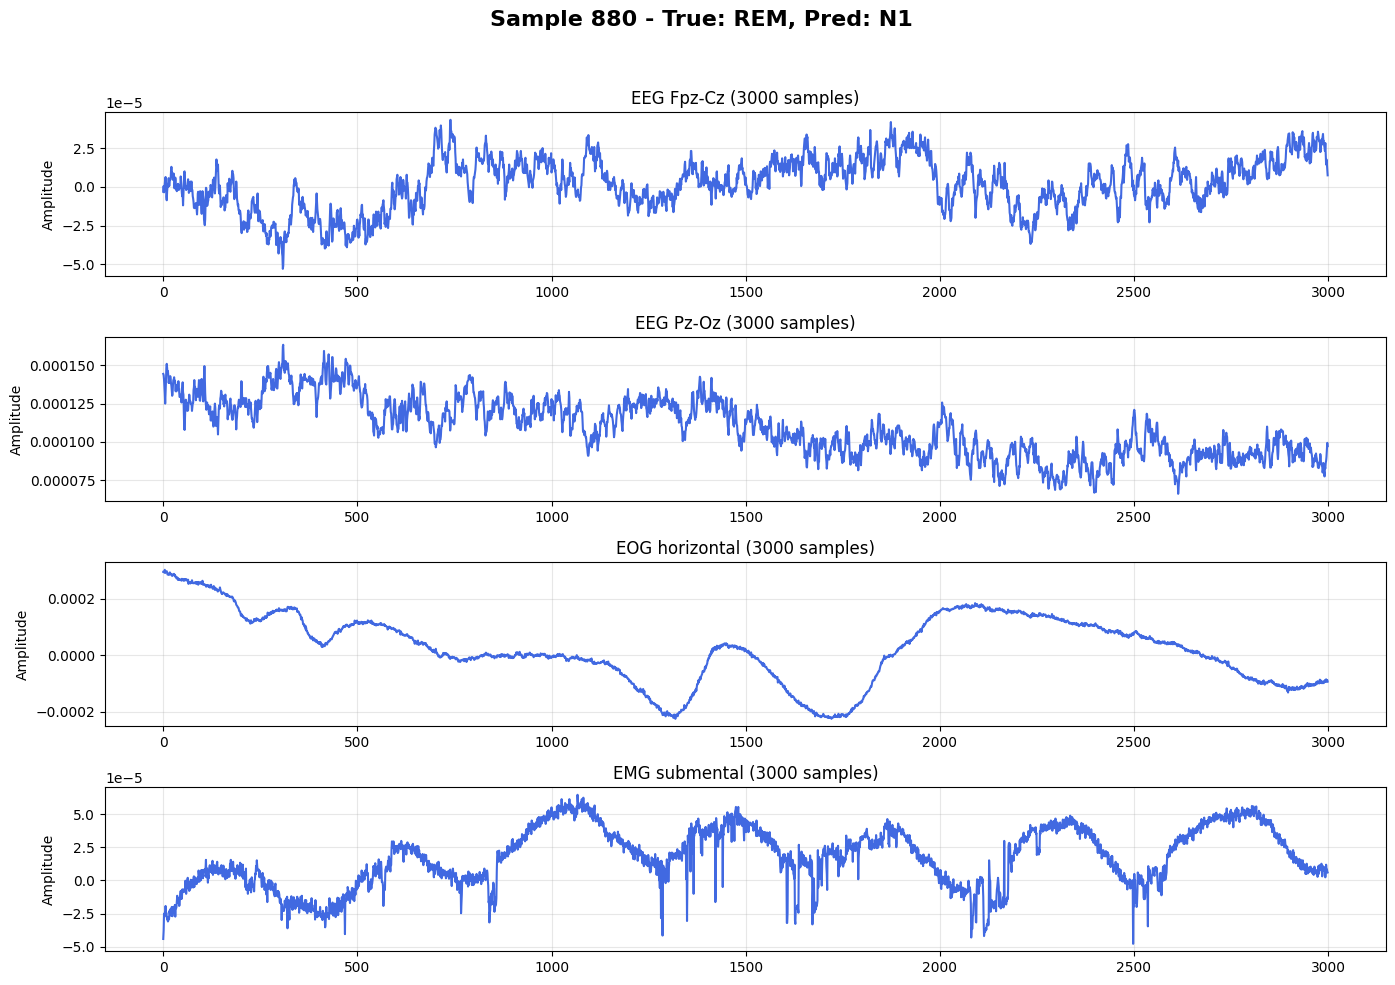


Example False Negative:


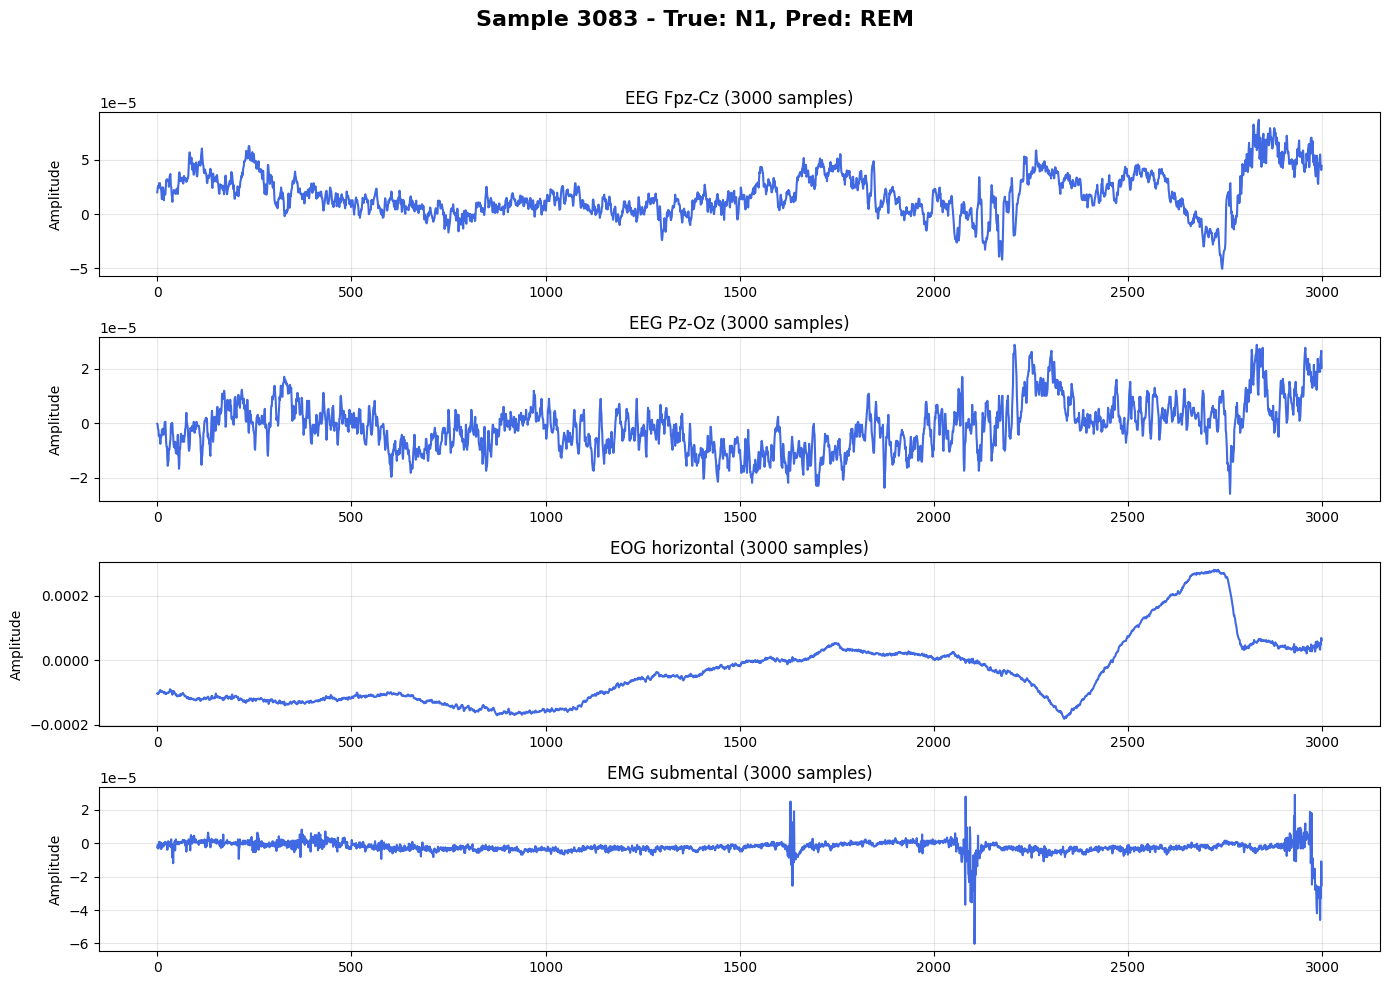


Example True Negative:


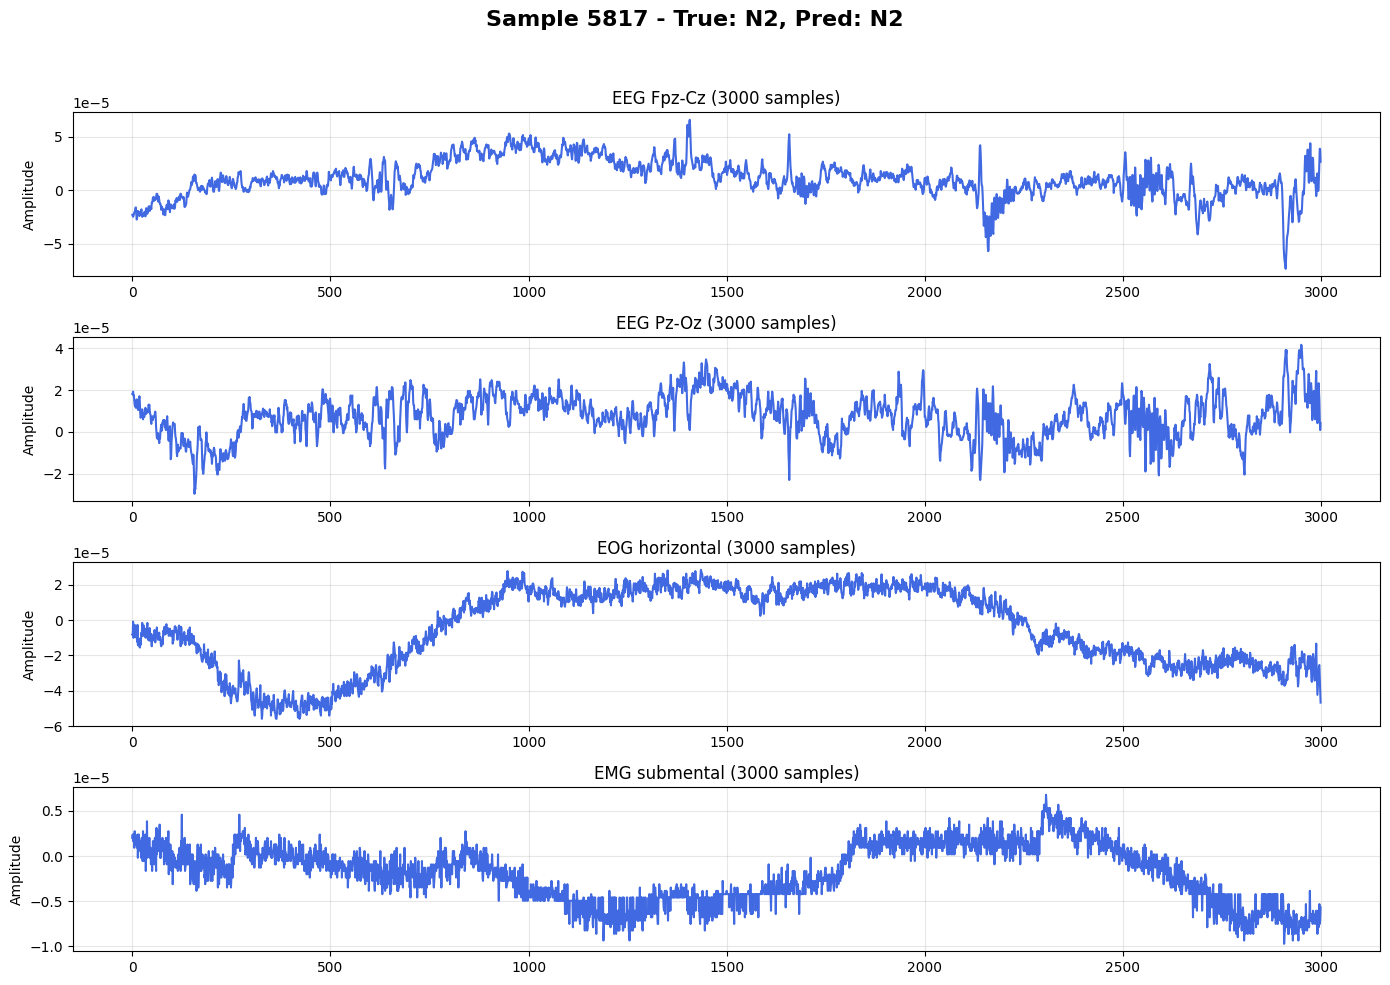


===== N2 Analysis =====
True Positives: 2332 samples
False Positives: 108 samples
False Negatives: 760 samples
True Negatives: 2733 samples

Example True Positive:


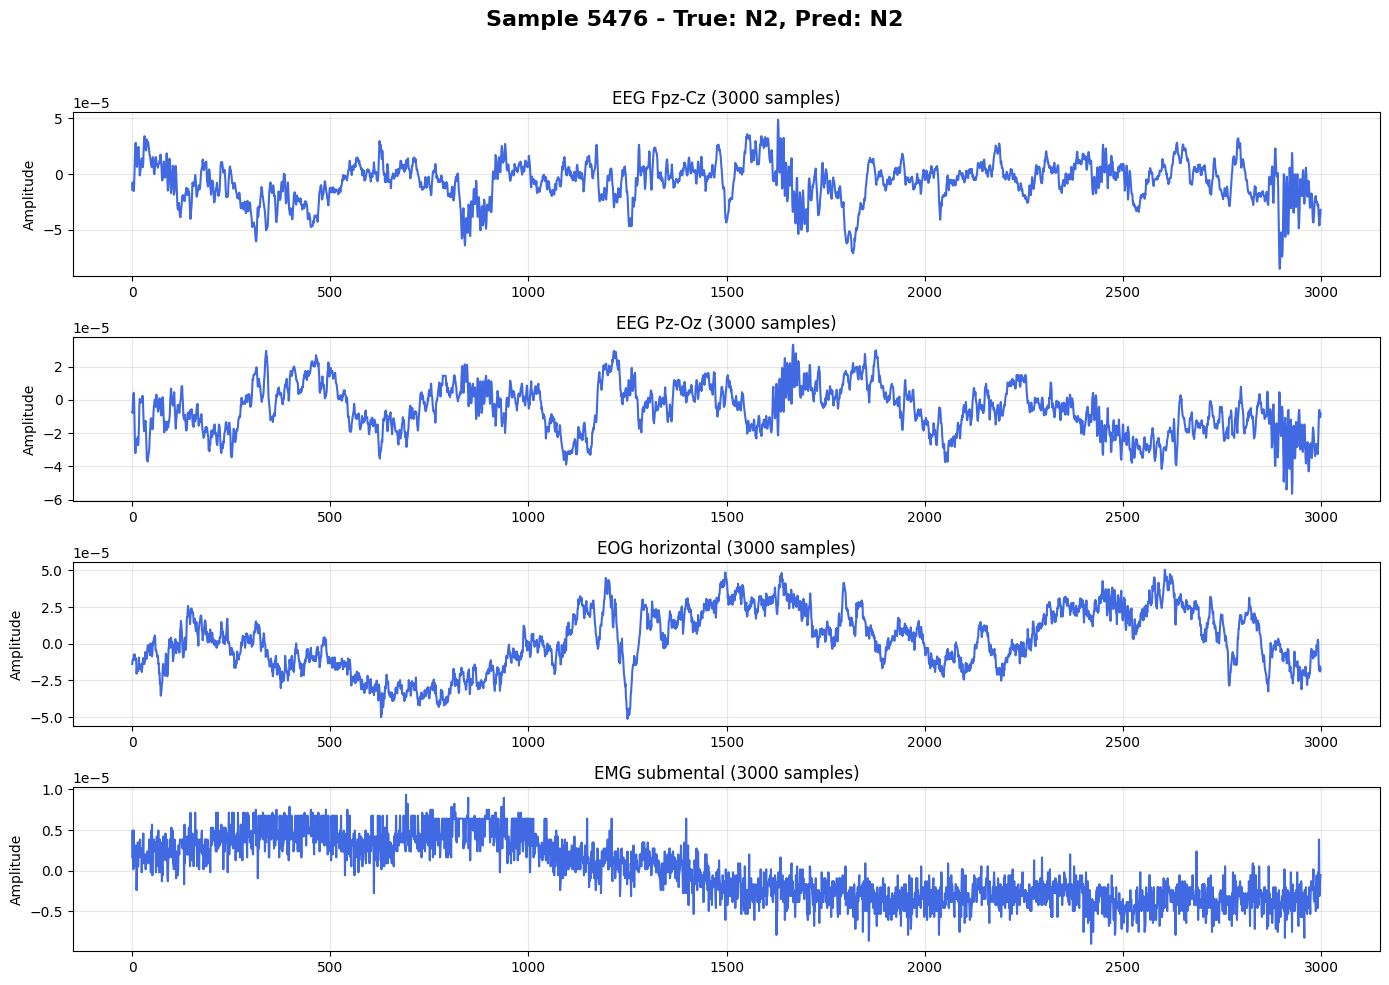


Example False Positive:


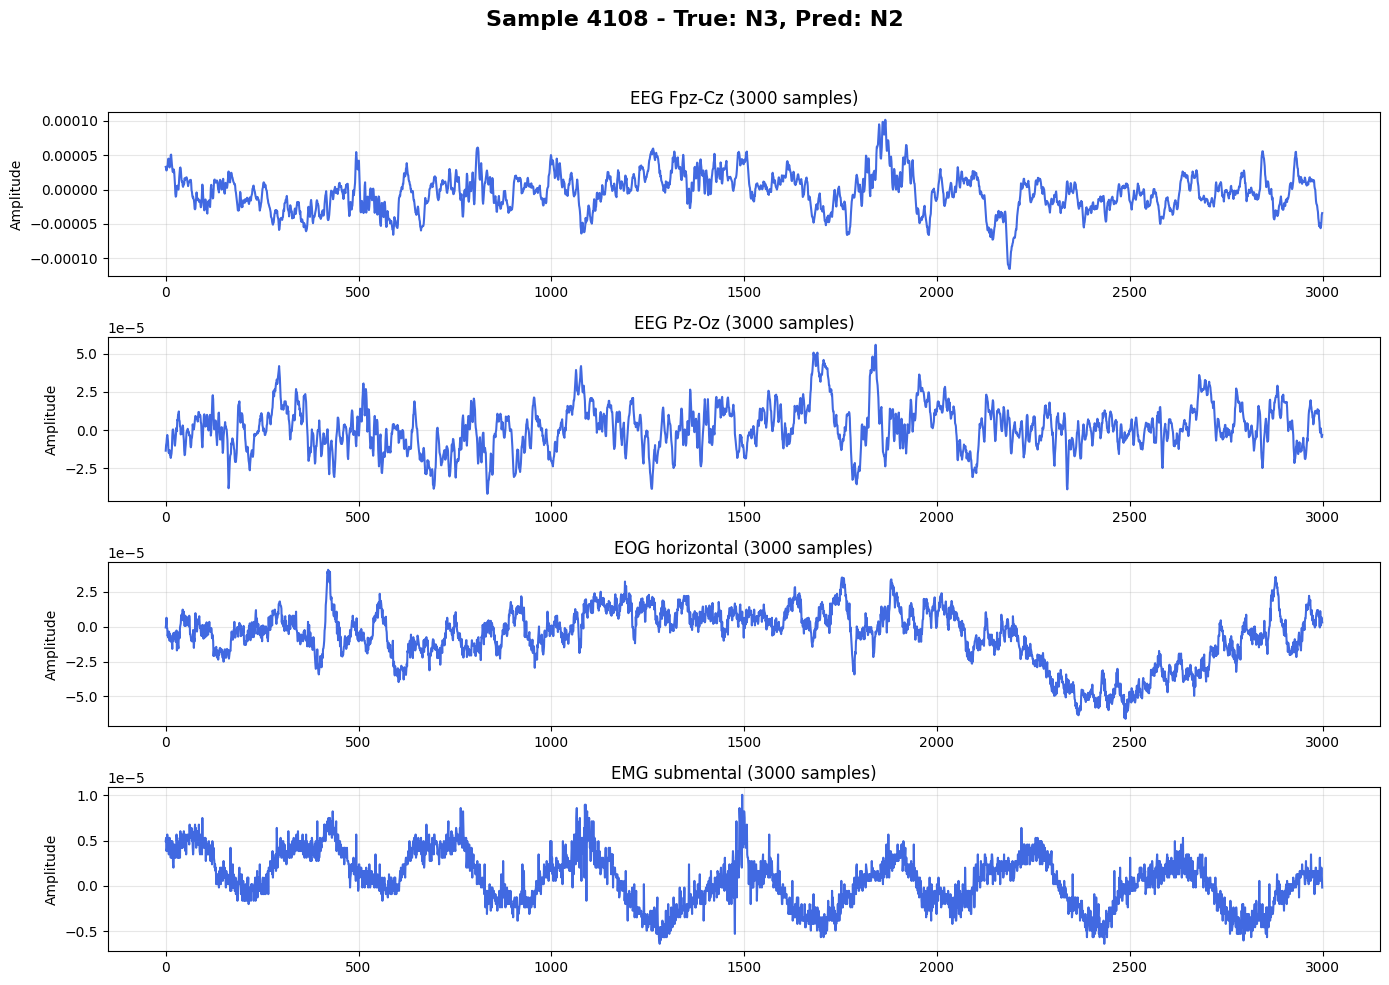


Example False Negative:


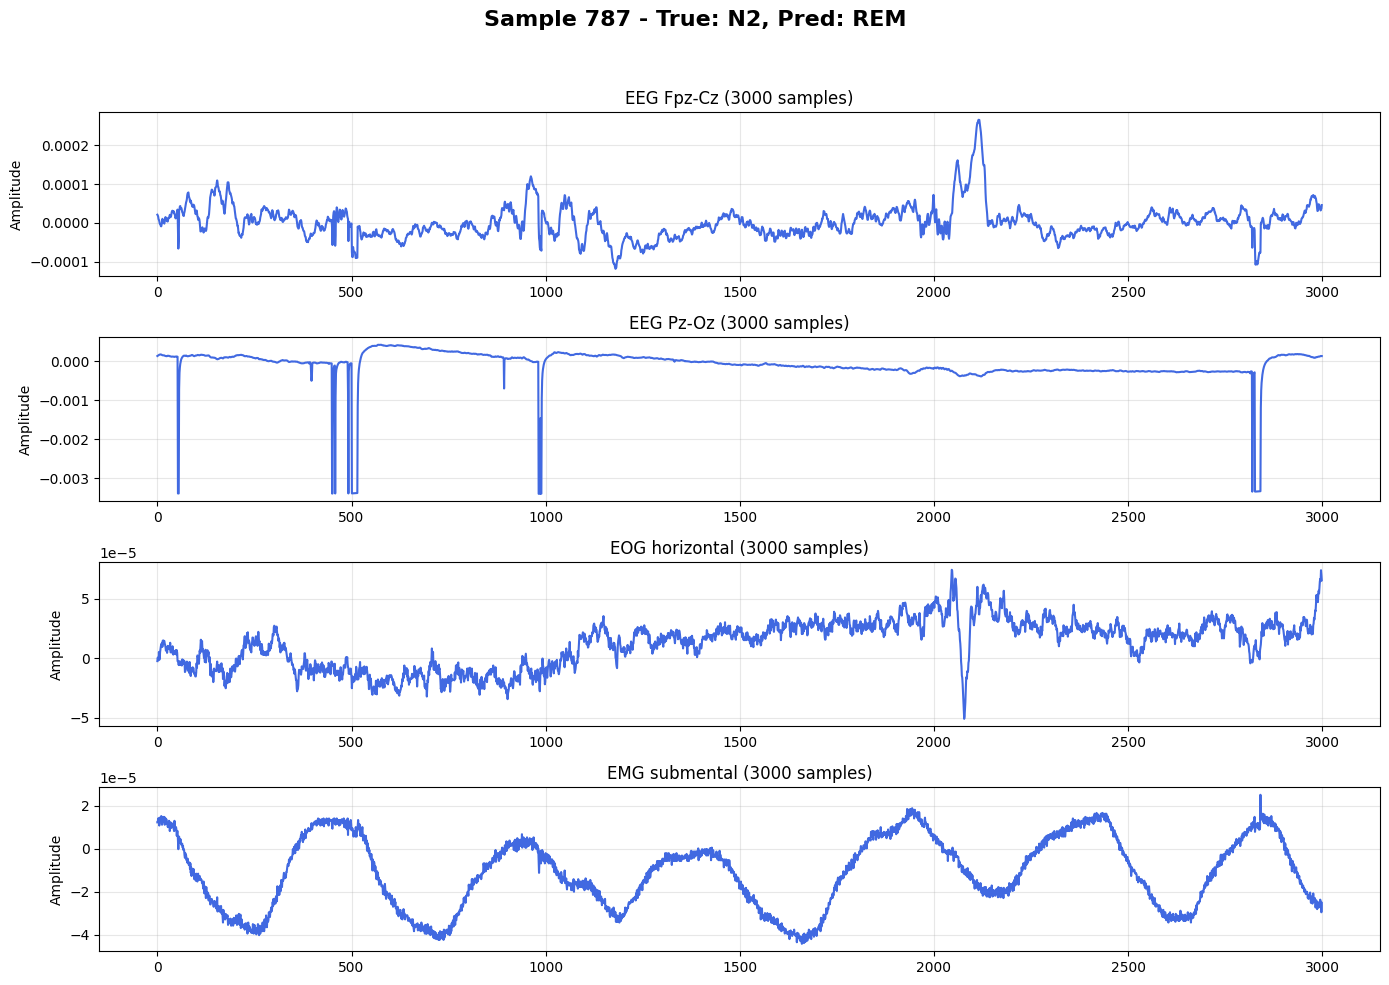


Example True Negative:


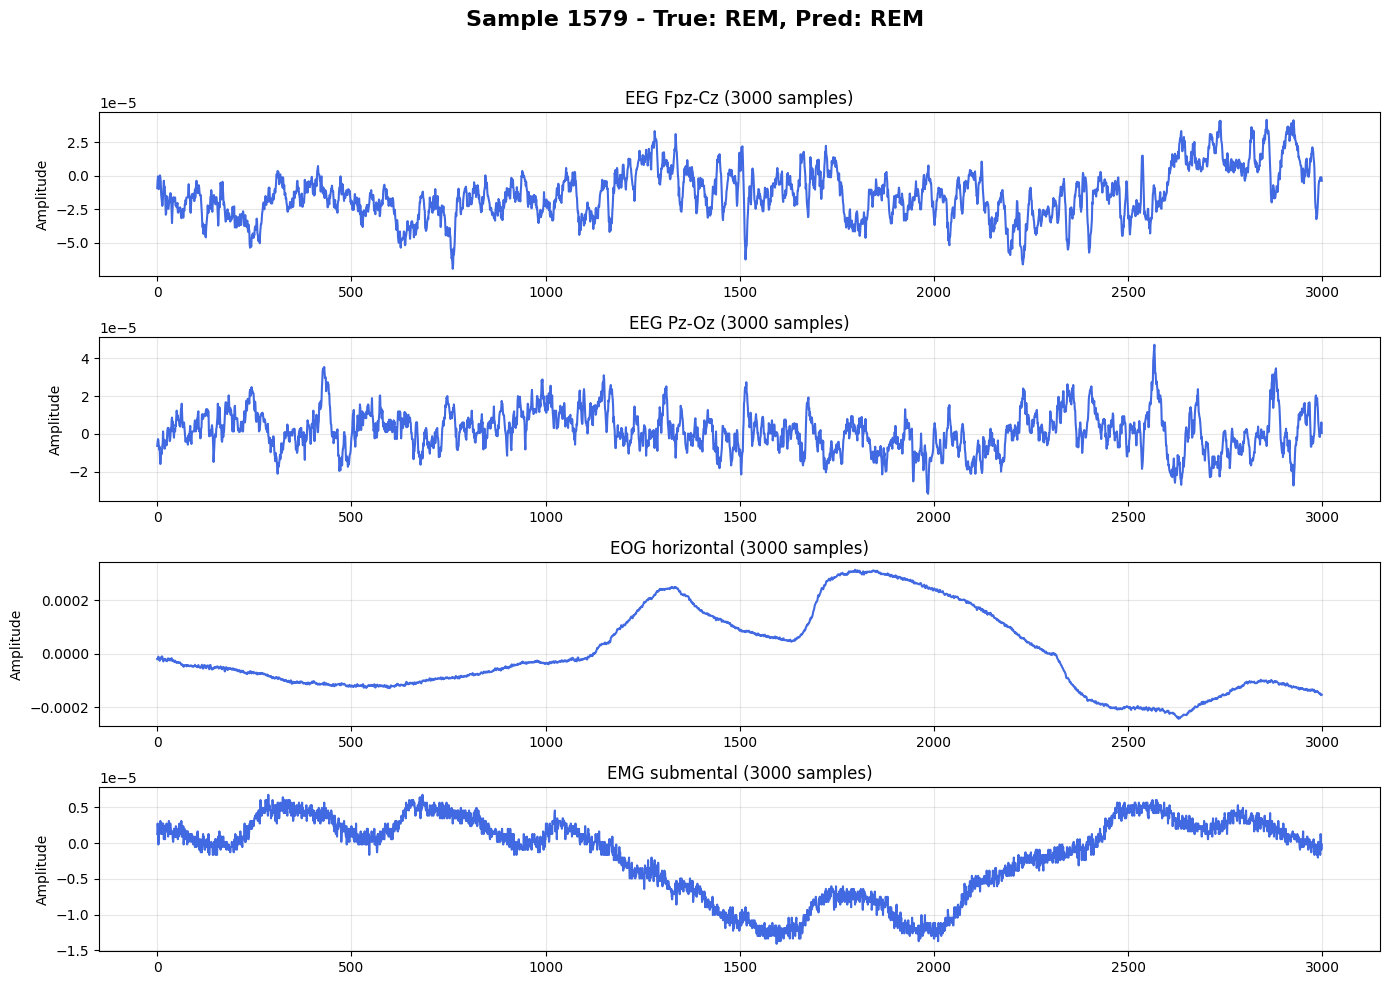


===== N3 Analysis =====
True Positives: 688 samples
False Positives: 356 samples
False Negatives: 30 samples
True Negatives: 4377 samples

Example True Positive:


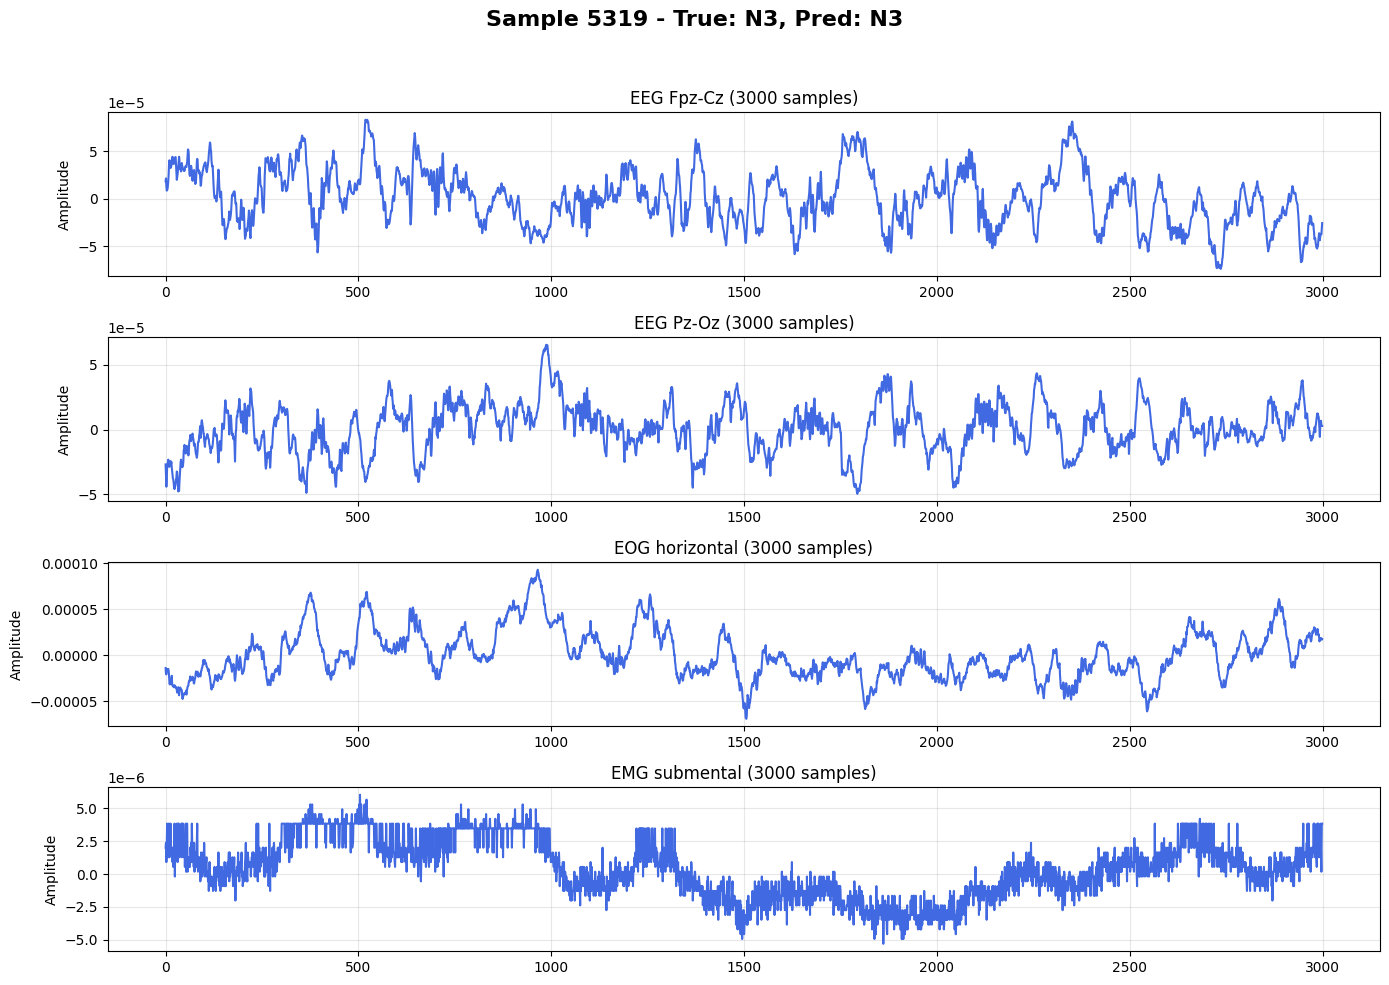


Example False Positive:


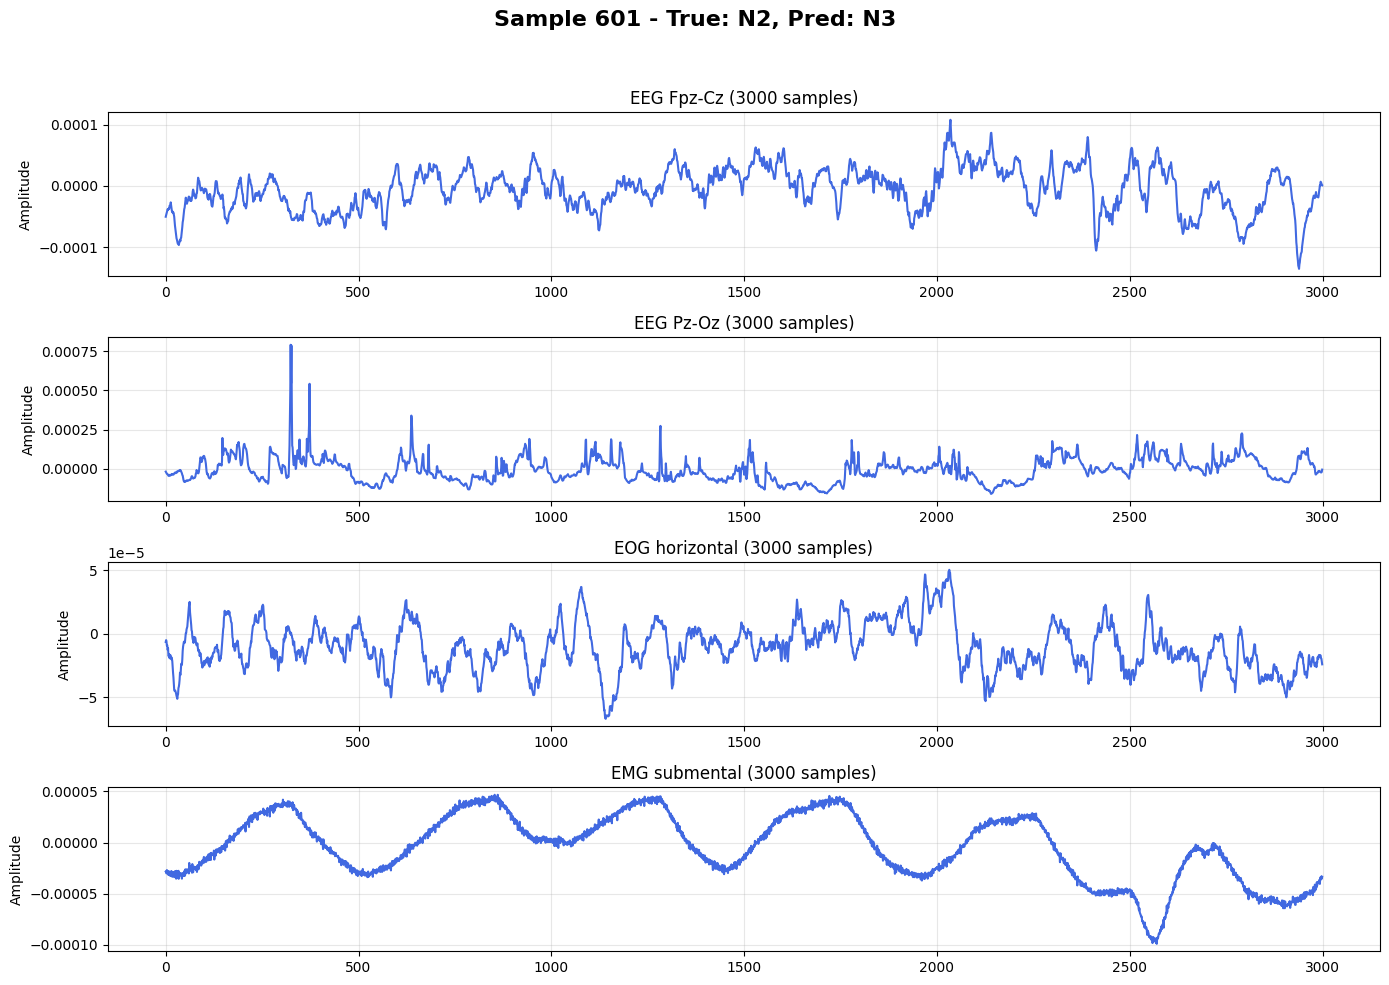


Example False Negative:


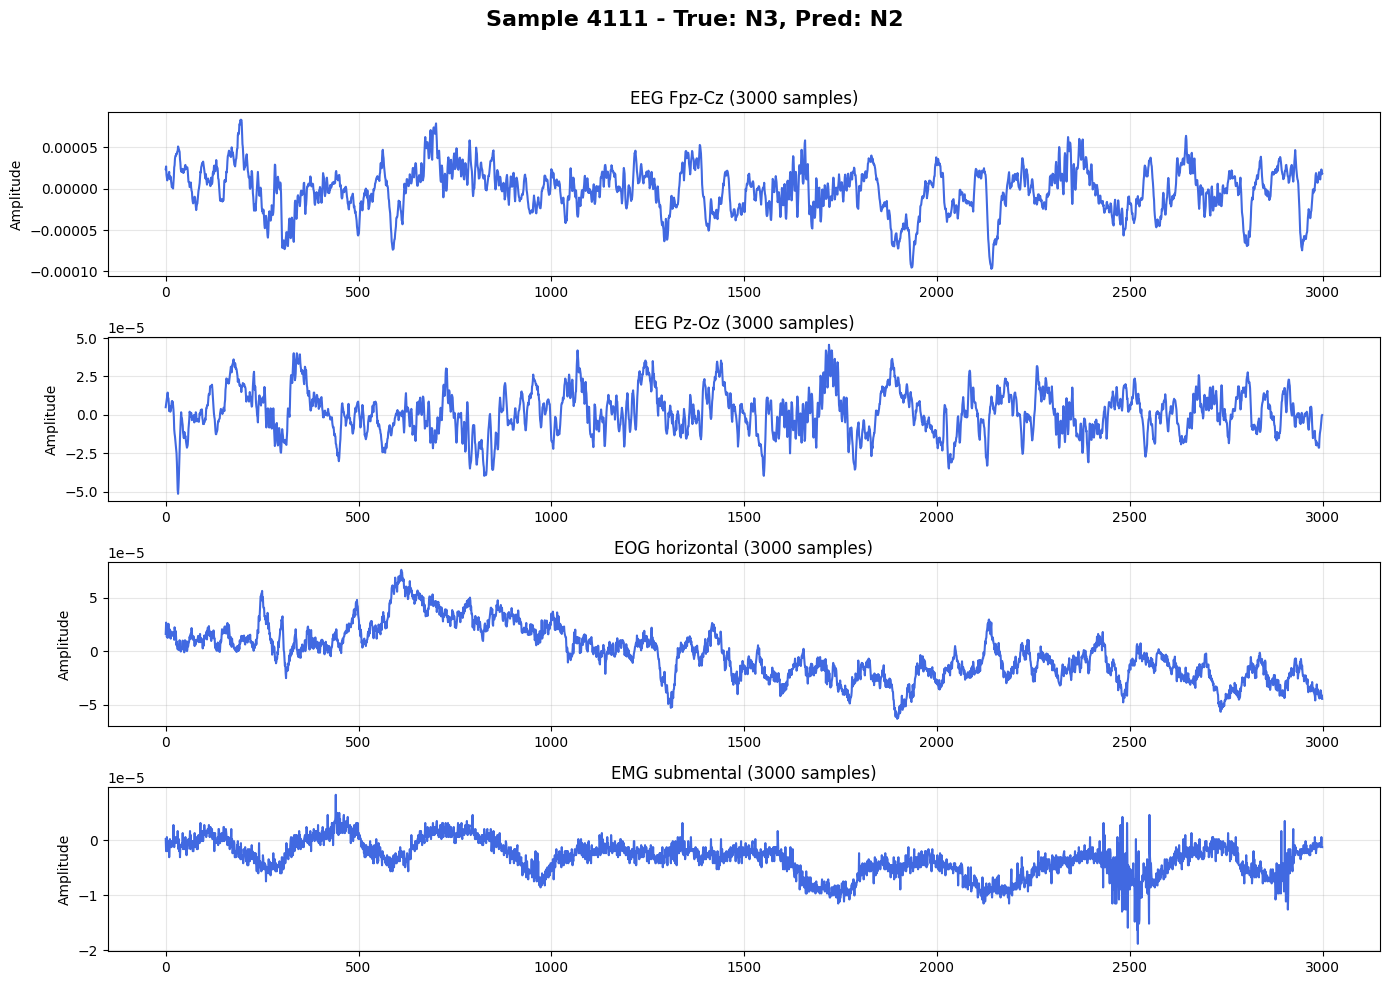


Example True Negative:


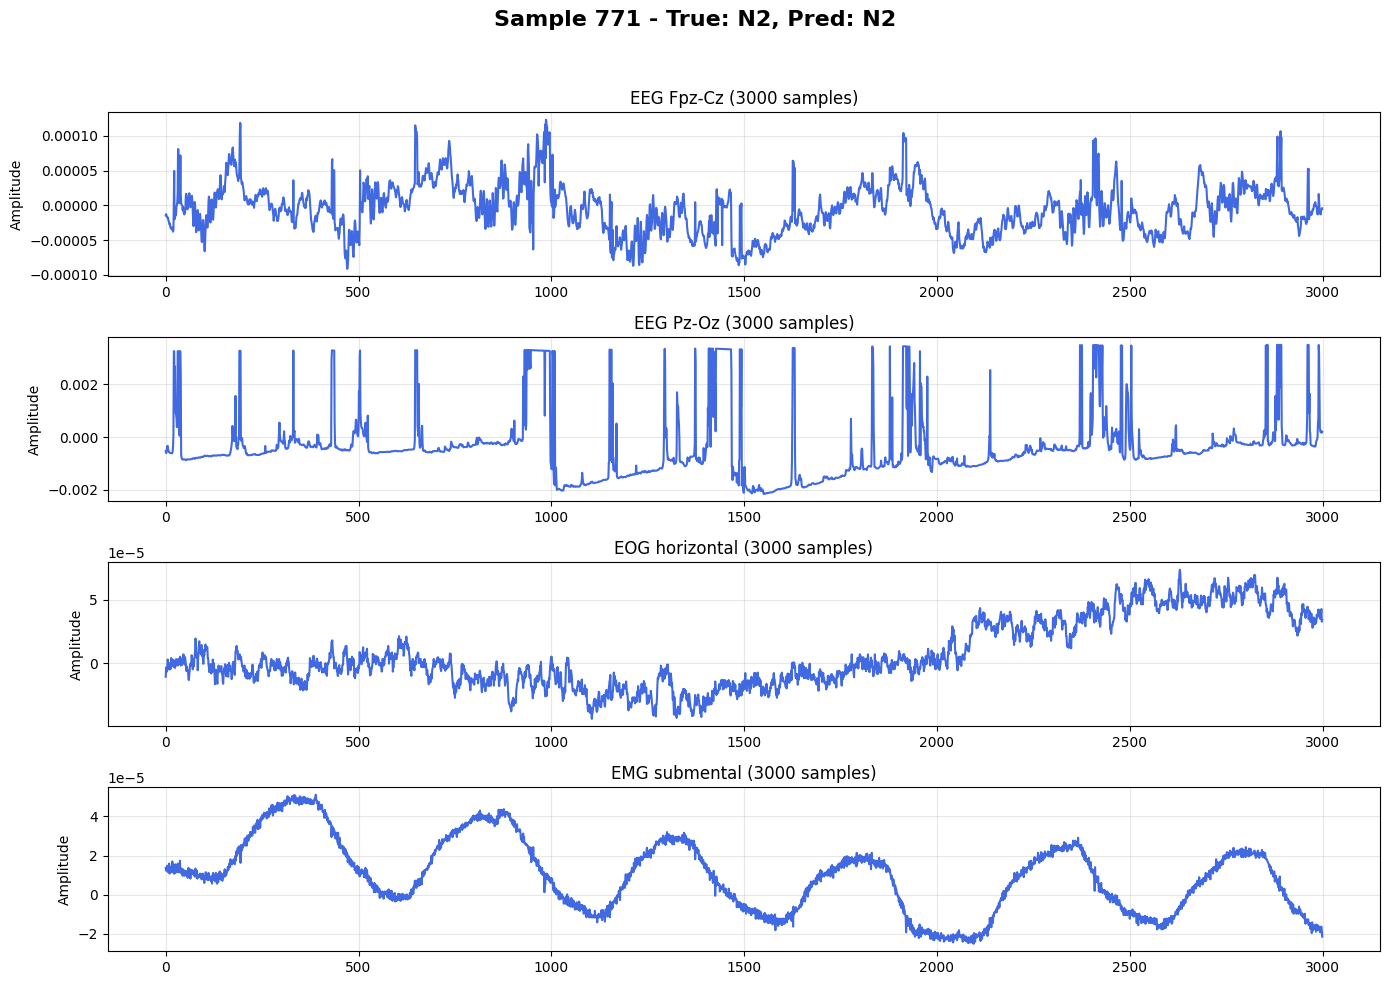


===== REM Analysis =====
True Positives: 1319 samples
False Positives: 352 samples
False Negatives: 83 samples
True Negatives: 3746 samples

Example True Positive:


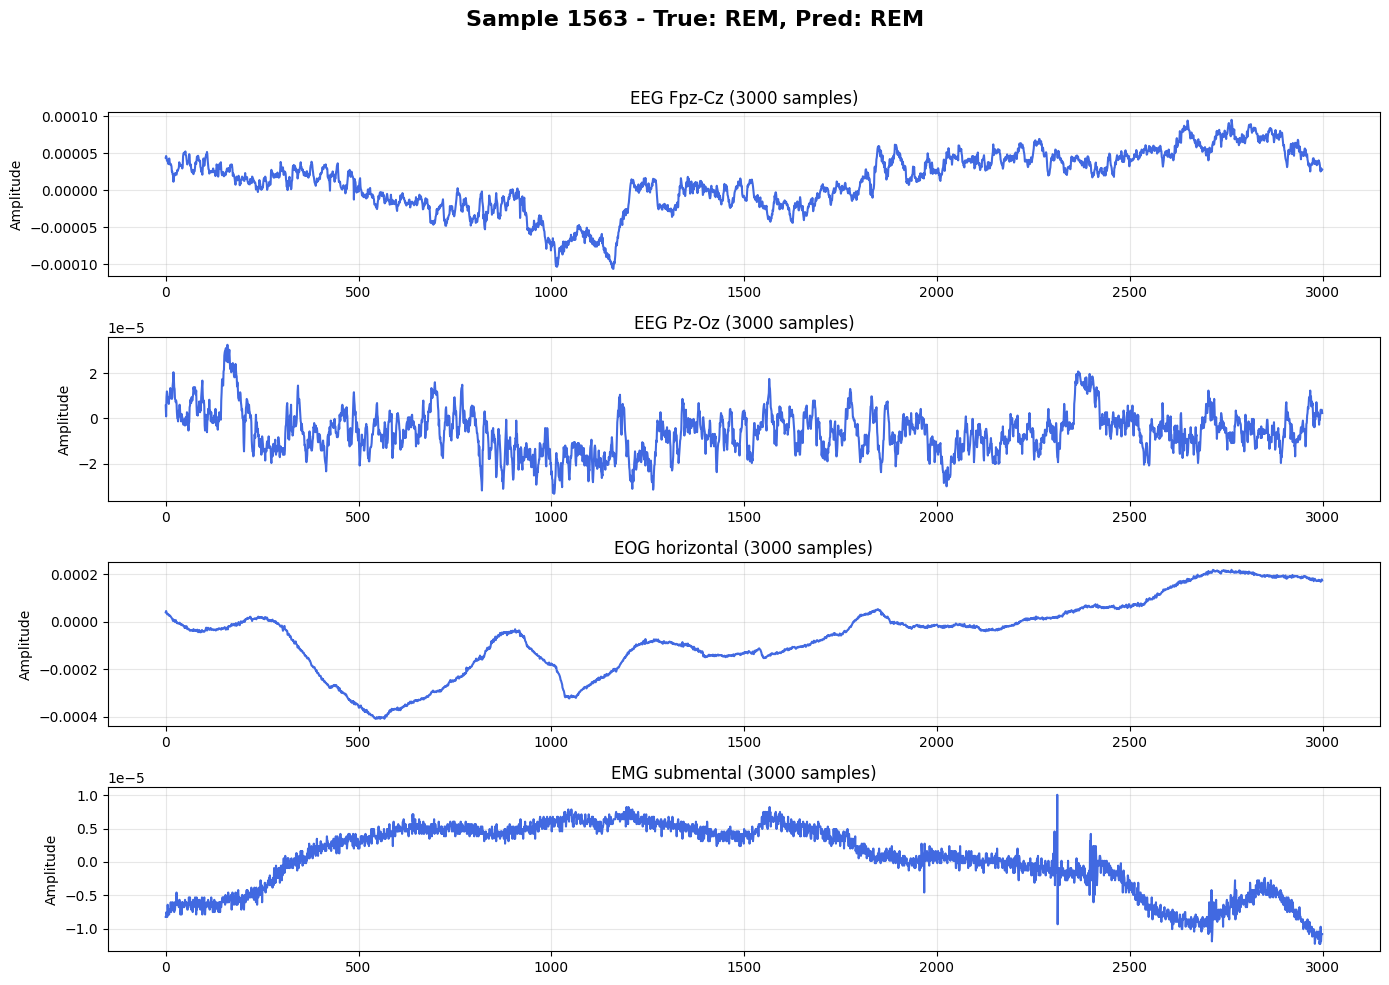


Example False Positive:


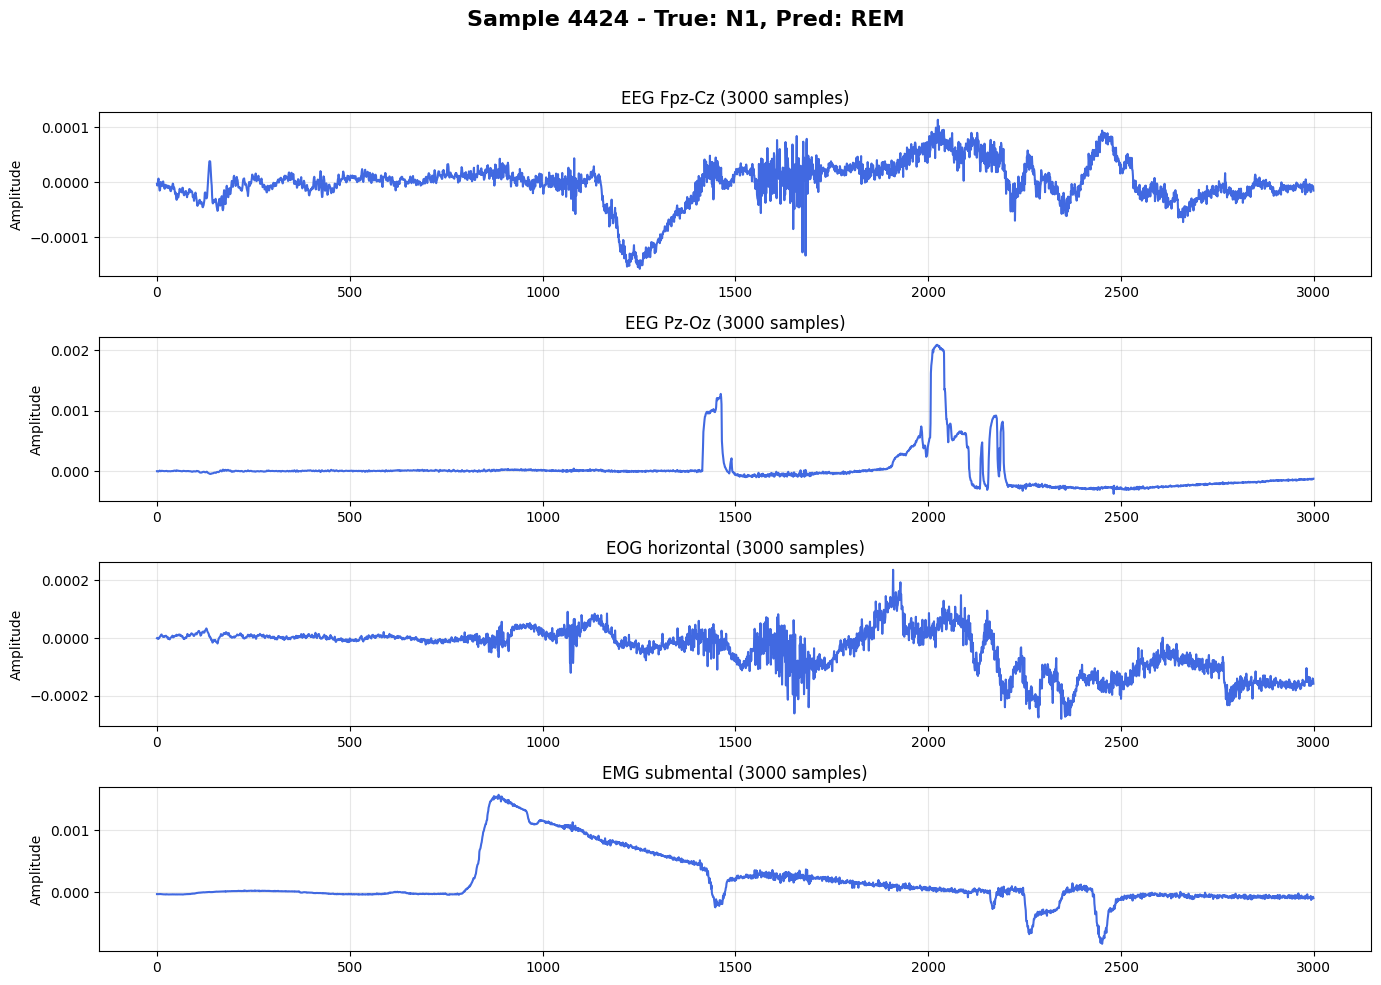


Example False Negative:


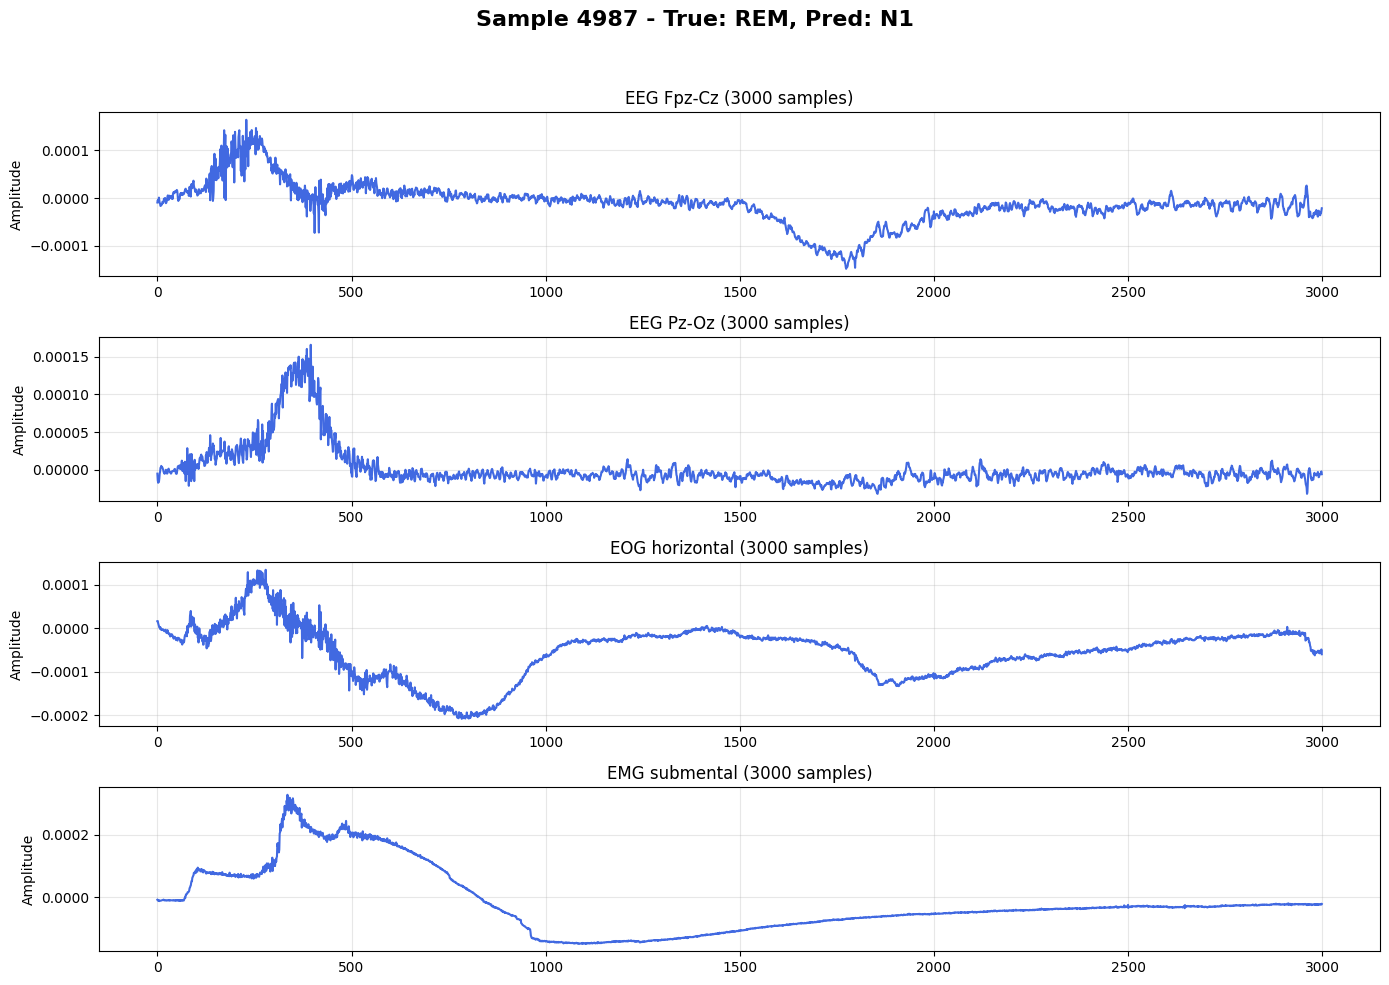


Example True Negative:


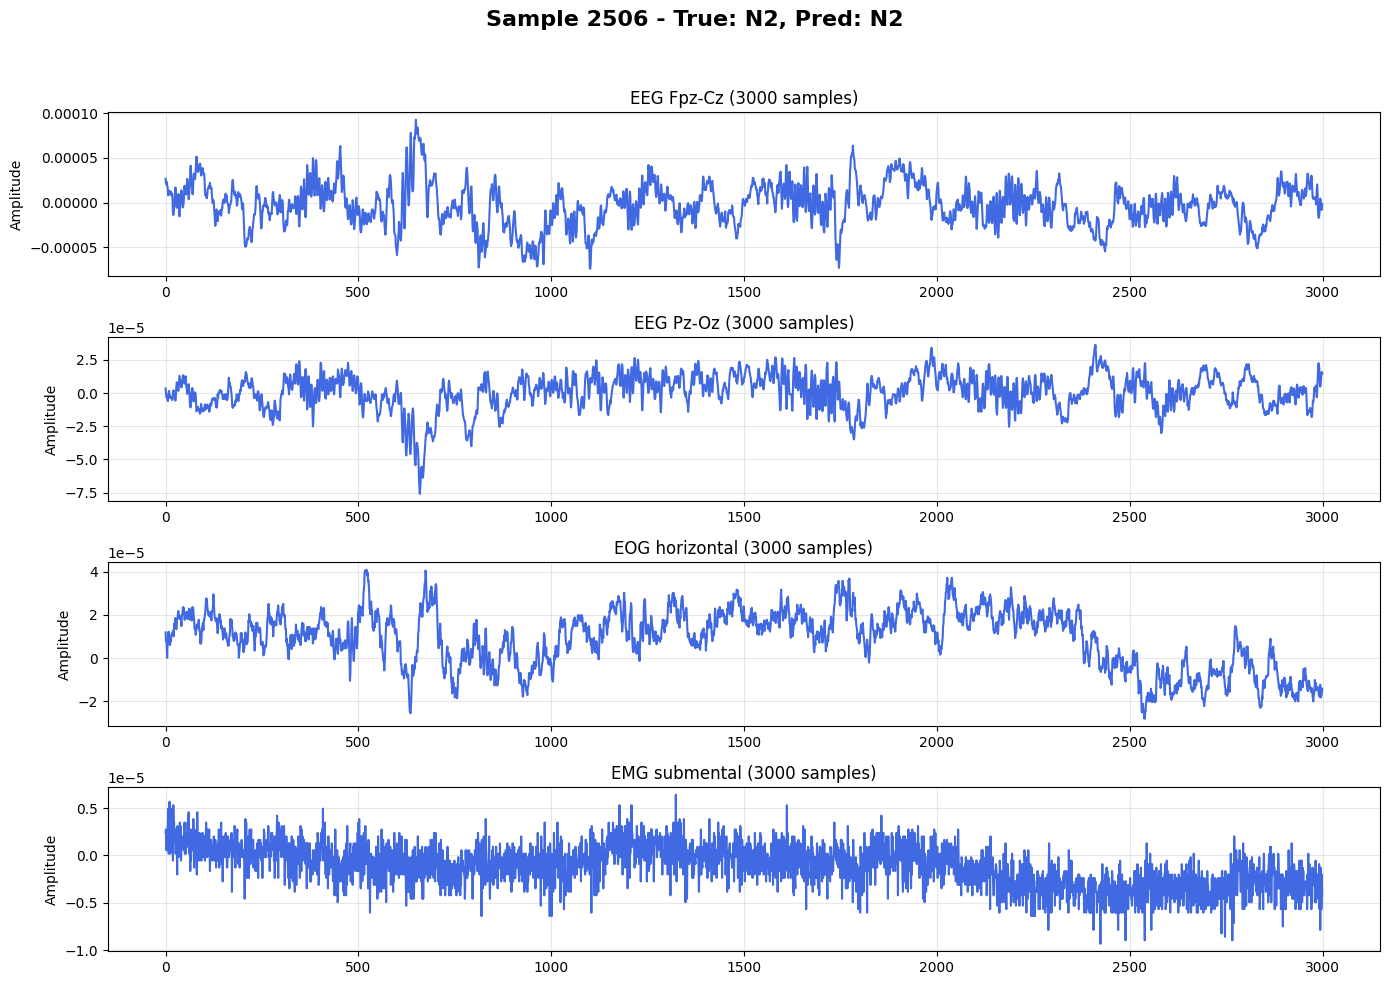

In [20]:
data_dict = np.load("/content/drive/MyDrive/sleepdata/telemetry_all_test.npz")
validation = {}
for key in data_dict.keys():
    validation[key] = data_dict[key][::]

all_true = []
all_preds = []
model.eval()

with torch.inference_mode():
    for i in range(len(validation["y"])):
        input_dict = {}
        for ch in ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal", "EMG submental"]:
            signal = validation[ch][i]
            input_dict[ch] = torch.tensor(signal, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        true_label = validation["y"][i]
        output = model(input_dict)
        pred_label = torch.argmax(output, dim=1).item()

        all_true.append(true_label)
        all_preds.append(pred_label)

all_true = np.array(all_true)
all_preds = np.array(all_preds)

print("\nTest Classification Report:")
print(classification_report(
    all_true,
    all_preds,
    target_names=class_names,
    digits=4,
    zero_division=0
))

print("\n\n\n\n")


analyze_predictions(
    model=model,
    device=device,
    data_dict=validation,
    class_names=class_names
)